In [333]:
import pandas as pd

df = pd.read_excel('./Data/online_retail.xlsx')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [334]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]
df['CustomerID'] = df['CustomerID'].astype('int')

df['Revenue'] = df['Quantity'] * df['UnitPrice']

# customer df with country 

In [335]:
customer_df =df.groupby('CustomerID')['Country'].nunique().reset_index()
customer_df[customer_df['Country']>1]

,CustomerID,Country
20,12370,2
38,12394,2
56,12417,2
60,12422,2
67,12429,2
69,12431,2
90,12455,2
92,12457,2


In [336]:
cus_df = df.groupby('CustomerID')['Country'].max().reset_index()

# Transaction trends

In [337]:

agg_df = df.groupby('InvoiceDate', as_index=False).count()
agg_df = agg_df.rename(columns={'CustomerID':'CustomerCount'})
agg_df['InvoiceDate'] = pd.to_datetime(agg_df['InvoiceDate']).dt.date


In [338]:
agg_df[['InvoiceDate']].min()

InvoiceDate    2010-12-01
dtype: object

In [339]:
agg_df[['InvoiceDate']].max()

InvoiceDate    2011-12-09
dtype: object

<Axes: xlabel='InvoiceDate'>

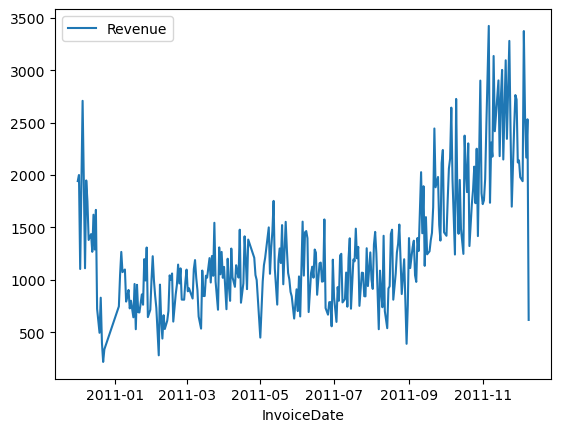

In [340]:
agg_df.plot(kind='line', x='InvoiceDate', y='Revenue')


In [341]:
#df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [342]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   StockCode    397924 non-null  object 
 2   Description  397924 non-null  object 
 3   Quantity     397924 non-null  int64  
 4   InvoiceDate  397924 non-null  object 
 5   UnitPrice    397924 non-null  float64
 6   CustomerID   397924 non-null  int64  
 7   Country      397924 non-null  object 
 8   Revenue      397924 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 30.4+ MB


# Historical Average

In [343]:
import pandas as pd
from datetime import datetime
import numpy as np
date_rng = pd.date_range(start='2010-11-30', end='2011-11-30', freq='M')
churn =  {"Month":[],"ChurnRate":[], "AvgRevenue":[]}

#append first month without churn rate
this_period  =df[(df['InvoiceDate']> date_rng[0].date()) & (df['InvoiceDate']<= date_rng[1].date()) ]['CustomerID'].unique()
total_revenue =df[(df['InvoiceDate']> date_rng[0].date()) & (df['InvoiceDate']<= date_rng[1].date()) ]['Revenue'].sum()

churn["Month"].append(date_rng[1])
churn["ChurnRate"].append(np.nan)
churn["AvgRevenue"].append(int(total_revenue/len(this_period)))

#loop through the rest of the months
for i in range(len(date_rng)):
    try:
        last_period =df[(df['InvoiceDate']> date_rng[i].date()) & (df['InvoiceDate']<= date_rng[i+1].date()) ]['CustomerID'].unique()
        this_period  =df[(df['InvoiceDate']> date_rng[i+1].date()) & (df['InvoiceDate']<= date_rng[i+2].date()) ]['CustomerID'].unique()
        total_revenue =df[(df['InvoiceDate']> date_rng[i+1].date()) & (df['InvoiceDate']<= date_rng[i+2].date()) ]['Revenue'].sum()
        retained = np.intersect1d(last_period, this_period)
        churn["Month"].append(date_rng[i+2])
        churn["ChurnRate"].append((int((1-(len(retained)/len(last_period)))*100)))
        churn["AvgRevenue"].append(int(total_revenue/len(this_period)))
    except:
        pass

In [344]:
churn_df = pd.DataFrame(churn)
churn_df

,Month,ChurnRate,AvgRevenue
0,2010-12-31,NaN,647
1,2011-01-31,63.0,768
2,2011-02-28,64.0,589
3,2011-03-31,61.0,611
4,2011-04-30,68.0,548
5,2011-05-31,57.0,642
6,2011-06-30,61.0,667
7,2011-07-31,63.0,632
8,2011-08-31,59.0,690
9,2011-09-30,54.0,752


In [345]:
churn_df.mean().round(0)

ChurnRate      60.0
AvgRevenue    667.0
dtype: float64

## Lifetime months

In [346]:
round(100/60,2)

1.67

## Lifetime value

In [347]:
round(667*(100/60))

1112

# RFM

In [348]:
cutoff_date = pd.to_datetime("2011-09-01").date()
end_date = pd.to_datetime("2011-12-01").date()


In [349]:
def return_data(train_df, final_date):
    max_date = train_df.groupby('CustomerID', as_index=False).agg({'InvoiceDate':'max'})
    max_date = max_date.rename(columns={"InvoiceDate": "MaxDate"}).set_index('CustomerID')
    min_date = train_df.groupby('CustomerID', as_index=False).agg({'InvoiceDate':'min'})
    min_date = min_date.rename(columns={"InvoiceDate": "MinDate"}).set_index('CustomerID')
    freqeuncy = train_df.groupby('CustomerID', as_index=False).agg({'Revenue':'count'})
    freqeuncy = freqeuncy.rename(columns={"Revenue": "Freqeuncy"}).set_index('CustomerID')
    monetary = train_df.groupby('CustomerID', as_index=False).agg({'Revenue':'sum'})
    monetary = monetary.rename(columns={"Revenue": "Monetary"}).set_index('CustomerID')

    rmf_df = max_date.merge(min_date, left_index=True, right_index=True)\
        .merge(freqeuncy, left_index=True, right_index=True)\
            .merge(monetary, left_index=True, right_index=True).reset_index()

    rmf_df['CutoffDate'] = final_date
    rmf_df[['MinDate','MaxDate','CutoffDate']] = rmf_df[['MinDate','MaxDate', 'CutoffDate']].apply(pd.to_datetime)
    #calculate difference between dates
    rmf_df['Tenure'] = (rmf_df['CutoffDate'] - rmf_df['MinDate'])  / np.timedelta64(1, 'D')
    rmf_df['Recency'] = (rmf_df['CutoffDate'] - rmf_df['MaxDate'])  / np.timedelta64(1, 'D')
    rmf_df['Churn'] = rmf_df['Recency'].apply(lambda x: 1 if x >1 else 0)

    country_rmf_df =rmf_df.merge(cus_df, on=['CustomerID'])
    country_rmf_df['CountryGroup'] = country_rmf_df['Country'].apply(lambda x: 'United Kingdom' if x =='United Kingdom' else 'Others')
    country_rmf_df['TenureMonth'] =  country_rmf_df['Tenure']/30.5
    country_rmf_df['TenureMonth'] = country_rmf_df['TenureMonth'].astype('int')
    return country_rmf_df

In [350]:
train_df = return_data(df.loc[df['InvoiceDate']<=cutoff_date],cutoff_date )
test_df = return_data(df.loc[df['InvoiceDate']<=end_date], end_date)

# Kaplan Meier

In [351]:
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test

In [352]:
kmf = KaplanMeierFitter()
 
T=train_df['TenureMonth']
C=train_df['Churn'].astype(float)
 
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3324 total observations, 106 right-censored observations>

<Axes: title={'center': 'Kaplan-Meier Survival Curve'}, xlabel='timeline'>

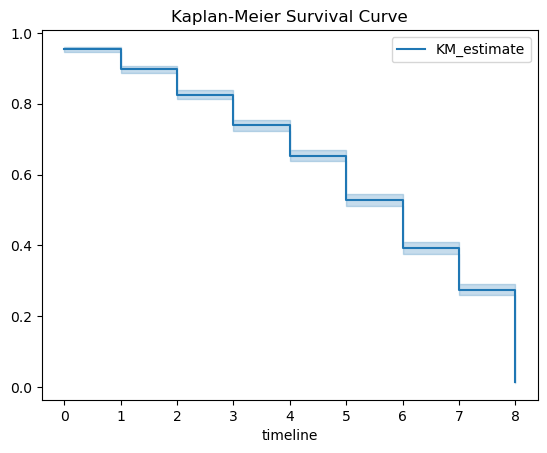

In [353]:
kmf.plot(title='Kaplan-Meier Survival Curve')

In [354]:
kmf.median_survival_time_

6.0

In [355]:
pd.DataFrame(kmf.survival_function_at_times(range(0,7)))

,KM_estimate
0,0.953971
1,0.897162
2,0.826055
3,0.739660
4,0.653801
5,0.527298
6,0.393716


In [356]:
# Construct dataframe with values from widgets

 
def get_kmf_payback_df():
  irr = 0
  cohort_df = pd.concat([pd.DataFrame([1.00]),kmf.survival_function_at_times(range(1,7))]).rename(columns={0:'Survival Probability'})
  cohort_df['Contract Month'] = cohort_df.index.astype('int')
  cohort_df['Monthly Profit for the Selected Plan'] = 667
  cohort_df['Avg Expected Monthly Profit'] = round(cohort_df['Survival Probability'] * cohort_df['Monthly Profit for the Selected Plan'],2)
  cohort_df['NPV of Avg Expected Monthly Profit'] = round(cohort_df['Avg Expected Monthly Profit'] / ((1+irr)**cohort_df['Contract Month']),2)
  cohort_df['Cumulative NPV'] = cohort_df['NPV of Avg Expected Monthly Profit'].cumsum()
  cohort_df['Contract Month'] = cohort_df['Contract Month'] + 1
  return cohort_df[['Contract Month','Survival Probability','Monthly Profit for the Selected Plan','Avg Expected Monthly Profit','NPV of Avg Expected Monthly Profit','Cumulative NPV']].set_index('Contract Month')


In [357]:
kmf_survival_lookup =get_kmf_payback_df().reset_index()
kmf_df = test_df[test_df['TenureMonth'].isin([0,1,2])].merge(kmf_survival_lookup, left_on=['TenureMonth'], right_on='Contract Month')

from sklearn.metrics import mean_absolute_error
mean_absolute_error(kmf_df['Monetary'], kmf_df['Cumulative NPV'])

612.1758432267884

In [358]:
import matplotlib.pyplot as plt
# Helper function for plotting Kaplan-Meier curves at the covariate level
def plot_km(col):
  ax = plt.subplot(111)
  for r in train_df[col].unique():
    ix = train_df[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    kmf.plot(ax=ax)
    
# Helper function for printing out Log-rank test results
def print_logrank(col):
  log_rank = pairwise_logrank_test(train_df['TenureMonth'], train_df[col], train_df['Churn'])
  return log_rank.summary

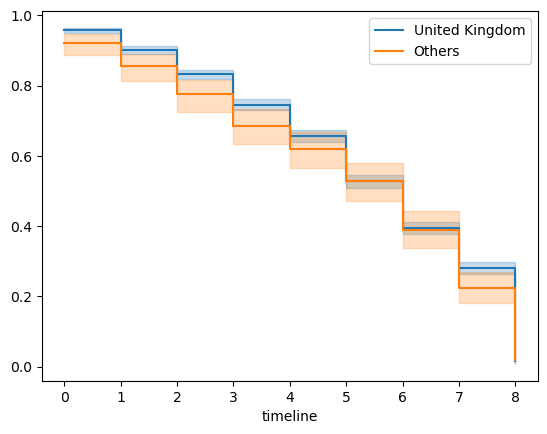

In [359]:
plot_km('CountryGroup')

In [360]:
print_logrank('CountryGroup')

,,test_statistic,p,-log2(p)
Others,United Kingdom,2.885866,0.08936,3.484228


In [361]:
kmf.median_survival_time_

6.0

In [362]:
def get_survival_probs(col,val):
  ix = train_df[col] == val
  return kmf.fit(T[ix],C[ix],label=val)  

In [363]:
sp_internet_dsl = get_survival_probs('Country','United Kingdom')

In [364]:
pd.DataFrame(sp_internet_dsl.survival_function_at_times(range(0,10)))

,United Kingdom
0,0.957582
1,0.901569
2,0.831701
3,0.745535
4,0.657607
5,0.527234
6,0.394067
7,0.280794
8,0.015159
9,0.015159


# Cox

In [365]:
encode_cols = ['CountryGroup']
 
encoded_pd = pd.get_dummies(train_df,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)
 
encoded_pd.head()

,CustomerID,MaxDate,MinDate,Freqeuncy,Monetary,CutoffDate,Tenure,Recency,Churn,Country,TenureMonth,CountryGroup_Others,CountryGroup_United Kingdom
0,12346,2011-01-18,2011-01-18,1,77183.60,2011-09-01,226.0,226.0,1,United Kingdom,7,0,1
1,12347,2011-08-02,2010-12-07,124,2790.86,2011-09-01,268.0,30.0,1,Iceland,8,1,0
2,12348,2011-04-05,2010-12-16,28,1487.24,2011-09-01,259.0,149.0,1,Finland,8,1,0
3,12350,2011-02-02,2011-02-02,17,334.40,2011-09-01,211.0,211.0,1,Norway,6,1,0
4,12352,2011-03-22,2011-02-16,38,1561.81,2011-09-01,197.0,163.0,1,Norway,6,1,0


In [366]:
survival_pd = encoded_pd[['Churn','TenureMonth','CountryGroup_Others','CountryGroup_United Kingdom']]

In [367]:
survival_pd.loc[:,'Churn'] = survival_pd.loc[:,'Churn'].astype('float')
survival_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3324 entries, 0 to 3323
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        3324 non-null   float64
 1   TenureMonth                  3324 non-null   int64  
 2   CountryGroup_Others          3324 non-null   uint8  
 3   CountryGroup_United Kingdom  3324 non-null   uint8  
dtypes: float64(1), int64(1), uint8(2)
memory usage: 84.4 KB


/var/folders/tw/8wdkdtvs1fv8ftrnn4f5vt540000gn/T/ipykernel_31530/2656172636.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  survival_pd.loc[:,'Churn'] = survival_pd.loc[:,'Churn'].astype('float')


In [368]:
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

cph = CoxPHFitter(alpha=0.01,penalizer=0.01)
cph.fit(survival_pd, 'TenureMonth', 'Churn')

<lifelines.CoxPHFitter: fitted with 3324 total observations, 106 right-censored observations>

In [369]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3324 total observations, 106 right-censored observations>
             duration col = 'TenureMonth'
                event col = 'Churn'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 3324
number of events observed = 3218
   partial log-likelihood = -23062.65
         time fit was run = 2023-05-01 16:33:27 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 99%   coef upper 99%  exp(coef) lower 99%  exp(coef) upper 99%
covariate                                                                                                                           
CountryGroup_Others           0.04       1.04       0.41            -1.02             1.10                 0.36                 2.99
CountryGroup_United Kingdom  -0.04       0.96       0.41            -1.10             1.02                 0.33                 2.78

                              cmp to     z    p   -log2(p)
covariate                                                 
CountryGroup_Others             0.00  0.09 0.93       0.11
CountryGroup_United Kingdom     0.00 -0.09 0.93       0.11
---
Concordance = 0.51
Partial AIC = 46129.31
log-likelihood ratio test = 1.58 on 2 df
-log2(p) of ll-ratio test = 1.14

<Axes: xlabel='HR (99% CI)'>

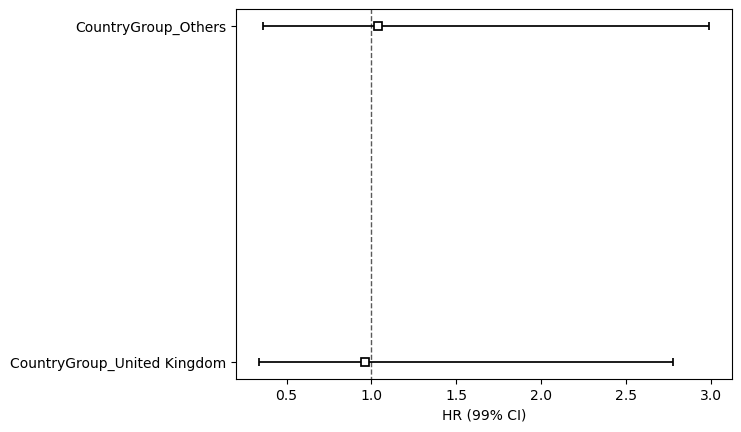

In [370]:
cph.plot(hazard_ratios=True)

In [371]:
cph.check_assumptions(survival_pd,p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

In [372]:
 widget_dict= {'CountryGroup_Others':0,	'CountryGroup_United Kingdom':0,' internal rate of return':0.10}
 widget_dict_df = pd.DataFrame.from_dict(widget_dict,orient='index').T

In [373]:
cph.predict_survival_function(widget_dict_df)

,0
0.0,0.953691
1.0,0.896930
2.0,0.826585
3.0,0.742122
4.0,0.658440
5.0,0.539412
6.0,0.415521
7.0,0.304710
8.0,0.115113


In [374]:
# Construct dataframe with values from widgets

 
def get_cph_payback_df():
  irr = widget_dict_df[' internal rate of return'].astype('float64')[0]/12
  cohort_df = pd.concat([round(cph.predict_survival_function(widget_dict_df),2)]).rename(columns={0:'Survival Probability'})
  cohort_df['Contract Month'] = cohort_df.index.astype('int')
  cohort_df['Monthly Profit for the Selected Plan'] = 667
  cohort_df['Avg Expected Monthly Profit'] = round(cohort_df['Survival Probability'] * cohort_df['Monthly Profit for the Selected Plan'],2)
  cohort_df['NPV of Avg Expected Monthly Profit'] = round(cohort_df['Avg Expected Monthly Profit'] / ((1+irr)**cohort_df['Contract Month']),2)
  cohort_df['Cumulative NPV'] = cohort_df['NPV of Avg Expected Monthly Profit'].cumsum()
  cohort_df['Contract Month'] = cohort_df['Contract Month'] + 1
  return cohort_df[['Contract Month','Survival Probability','Monthly Profit for the Selected Plan','Avg Expected Monthly Profit','NPV of Avg Expected Monthly Profit','Cumulative NPV']].set_index('Contract Month')


In [375]:
pd.options.display.max_rows = 25
get_cph_payback_df()[0:25]

,Survival Probability,Monthly Profit for the Selected Plan,Avg Expected Monthly Profit,NPV of Avg Expected Monthly Profit,Cumulative NPV
Contract Month,,,,,
1,0.95,667,633.65,633.65,633.65
2,0.90,667,600.30,595.34,1228.99
3,0.83,667,553.61,544.50,1773.49
4,0.74,667,493.58,481.44,2254.93
5,0.66,667,440.22,425.85,2680.78
6,0.54,667,360.18,345.54,3026.32
7,0.42,667,280.14,266.53,3292.85
8,0.30,667,200.10,188.81,3481.66
9,0.12,667,80.04,74.90,3556.56


In [376]:
cph_survival_lookup =get_cph_payback_df().reset_index()
cph_df = test_df[test_df['TenureMonth'].isin([0,1,2])].merge(cph_survival_lookup, left_on=['TenureMonth'], right_on='Contract Month')

from sklearn.metrics import mean_absolute_error
mean_absolute_error(cph_df['Monetary'], cph_df['Cumulative NPV'])

592.3693287671233

# BD/NBD

<lifetimes.BetaGeoFitter: fitted with 3324 subjects, a: 0.00, alpha: 47.43, b: 0.00, r: 0.52>


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

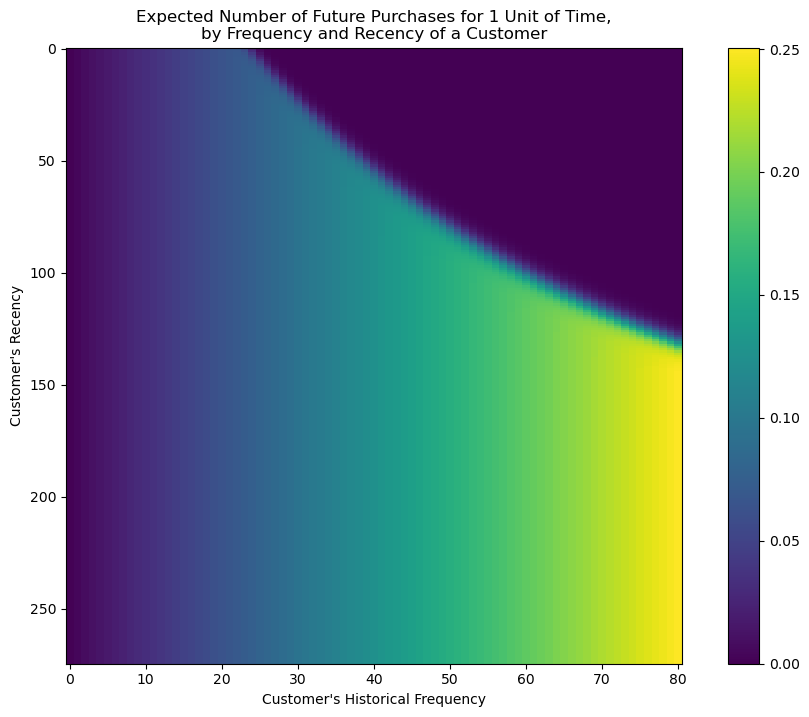

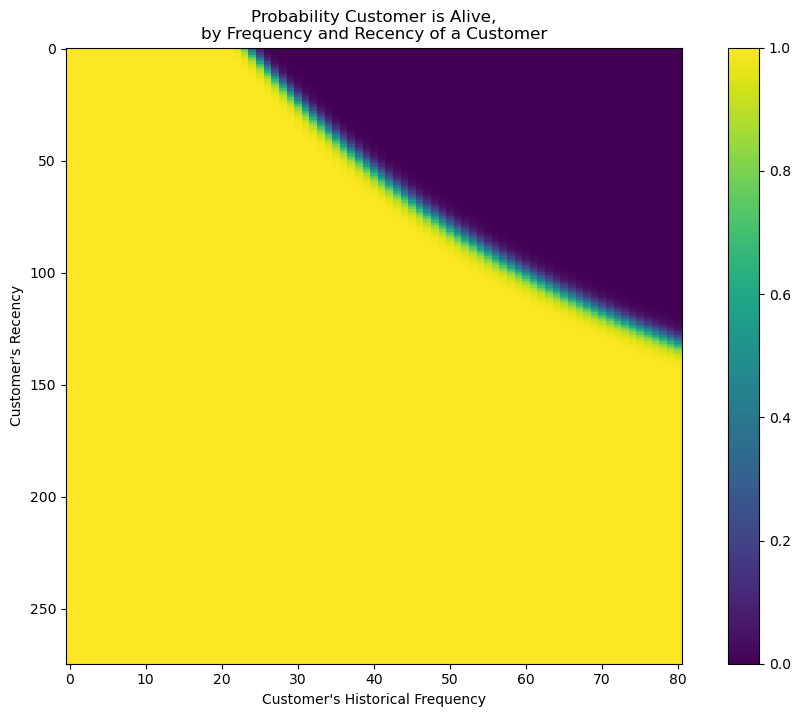

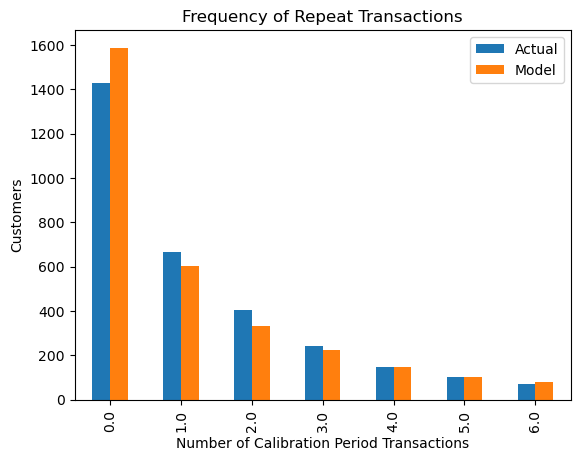

In [377]:
from lifetimes.plotting import *
from lifetimes.utils import *

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Revenue', observation_period_end='2011-09-01')
data.head()

from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

#predict a customer’s expected purchases in the next period using their history
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [378]:
df[df['CustomerID']==12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346,United Kingdom,77183.6


In [379]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-08-31',
                                        observation_period_end='2011-11-30' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346                 0.0          0.0  225.0                0.0   
12347                 4.0        238.0  267.0                1.0   
12348                 2.0        110.0  258.0                1.0   
12350                 0.0          0.0  210.0                0.0   
12352                 3.0         34.0  196.0                3.0   

            duration_holdout  
CustomerID                    
12346                   91.0  
12347                   91.0  
12348                   91.0  
12350                   91.0  
12352                   91.0  


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

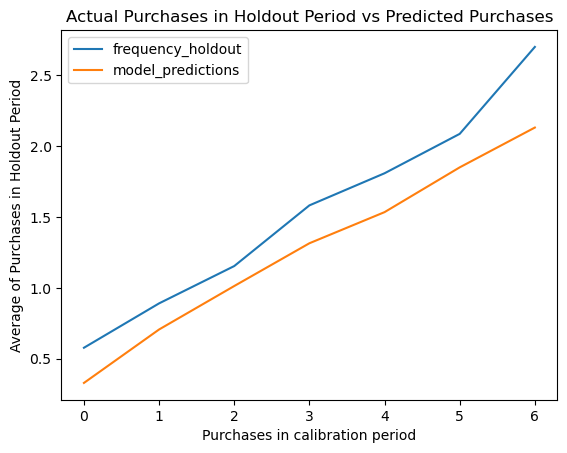

In [380]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

# Start here

In [381]:
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Revenue', observation_period_end='2011-09-01')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,226.0,0.0000
12347,4.0,238.0,268.0,519.7675
12348,2.0,110.0,259.0,297.2200
12350,0.0,0.0,211.0,0.0000
12352,3.0,34.0,197.0,421.7700


In [382]:
train_df1 = data.reset_index()

In [383]:
true_df = pd.DataFrame(df.loc[(df['InvoiceDate']>=cutoff_date)&(df['InvoiceDate']<end_date)].groupby('CustomerID')['Revenue'].sum()).reset_index()

In [384]:
train_df2 = train_df1.merge(true_df)

In [385]:
train_df2

,CustomerID,frequency,recency,T,monetary_value,Revenue
0,12347,4.0,238.0,268.0,519.767500,1294.32
1,12348,2.0,110.0,259.0,297.220000,310.00
2,12352,3.0,34.0,197.0,421.770000,944.23
3,12356,1.0,80.0,226.0,481.460000,58.35
4,12359,2.0,142.0,232.0,1474.115000,2876.85
...,...,...,...,...,...,...
1873,18270,0.0,0.0,167.0,0.000000,171.20
1874,18272,3.0,133.0,147.0,488.876667,604.25
1875,18273,0.0,0.0,158.0,0.000000,102.00
1876,18283,7.0,189.0,238.0,125.331429,901.11


In [386]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df2[['CustomerID','frequency',	'recency',	'T','monetary_value']], train_df2[['Revenue']], test_size=0.33, random_state=42)

In [387]:
returning_customers_summary = X_train[X_train['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

      CustomerID  frequency  recency      T  monetary_value
177        12836        2.0    174.0  212.0      632.920000
1392       16686        4.0    252.0  256.0      425.135000
628        14221        4.0    226.0  240.0      576.015000
86         12569        9.0    145.0  153.0      170.482222
1782       17937        4.0    248.0  263.0      555.240000
917


In [388]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)


<lifetimes.GammaGammaFitter: fitted with 917 subjects, p: 3.06, q: 3.27, v: 323.15>


In [389]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        X_train['frequency'],
        X_train['monetary_value']
    ).mean(),
    X_train[X_train['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 444.72453414684844, Average profit: 444.72403756216045


In [390]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(X_train['frequency'], X_train['recency'], X_train['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    X_train['frequency'],
    X_train['recency'],
    X_train['T'],
    X_train['monetary_value'],
    time=3, # months
    discount_rate=0 # monthly discount rate ~ 12.7% annually
).fillna(0).head(10))

781      89.766788
177     551.768983
1392    602.307248
628     825.868654
86      843.155664
1578    223.259657
1782    739.975708
457     278.660472
54      542.859086
1412      0.000000
Name: clv, dtype: float64


In [391]:
X_test = X_test.set_index('CustomerID')
y_test = y_test.set_index('CustomerID')

KeyError: "None of ['CustomerID'] are in the columns"

In [ ]:
pred = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    X_test['frequency'],
    X_test['recency'],
    X_test['T'],
    X_test['monetary_value'],
    time=3, # months
    discount_rate=0 # monthly discount rate ~ 12.7% annually
).fillna(0)

In [ ]:
pred_df = pd.DataFrame(pred).reset_index()

In [ ]:
y_test = pd.DataFrame(y_test).reset_index()

In [ ]:
fn_pred_df =pred_df.merge(y_test, left_index=True, right_index=True)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(fn_pred_df['Revenue'], fn_pred_df['clv'])

954.7715793485407

# ML

In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
model = reg.fit(X_train.drop(columns='CustomerID'), y_train)

/var/folders/tw/8wdkdtvs1fv8ftrnn4f5vt540000gn/T/ipykernel_31530/1019543585.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = reg.fit(X_train.drop(columns='CustomerID'), y_train)


In [ ]:
ml_pred = model.predict(X_test.reset_index().drop(columns='CustomerID'))

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ml_pred, y_test['Revenue'])

920.8654127145713